# TopicWeave: Domain Adaptation Fine-Tuning

This notebook implements domain-specific fine-tuning of the distilled SciBERT model
for the TopicWeave project. We fine-tune on specific scientific domains to improve
topic modeling performance.

## Setup

In [ ]:
!pip install -q transformers datasets torch scikit-learn numpy pandas matplotlib bertopic umap-learn hdbscan gensim

In [ ]:
!pip install -q bertopic

In [ ]:
!pip install -q gensim

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import json
from tqdm.auto import tqdm
from datetime import datetime

# Transformers and fine-tuning
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)

# For embedding and topic modeling
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

In [2]:
# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Define directories
PROJECT_DIR = '/content/drive/MyDrive/MIDS/W266/final_project/'
MODEL_DIR = f"{PROJECT_DIR}/models/"
EMBEDDING_DIR = f"{PROJECT_DIR}/embeddings/"
OUTPUT_DIR = f"{PROJECT_DIR}/domain_adaptation/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data and model preparation

In [4]:
# Load document data and select domains
def prepare_data(domains=None):
    """Load document data and prepare for domain adaptation"""
    # Load documents
    docs_df = pd.read_csv(f"{EMBEDDING_DIR}/document_info.csv")
    print(f"Loaded {len(docs_df)} documents")

    # Select domains for adaptation (Computer Science domains by default)
    if domains is None:
        domains = ["cs.AI", "cs.CL", "cs.CV", "cs.DL", "cs.LG", "math.ST", "physics.comp-ph", "q-bio.QM", "q-fin.ST", "stat.ML"]

    # Filter documents by domain
    domain_df = docs_df[docs_df['category'].isin(domains)]
    print(f"Selected {len(domain_df)} documents from domains: {domains}")

    return docs_df, domain_df

In [5]:
# Dataset class for Masked Learning Model (MLM)
class MLMDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [13]:
# Create datasets for fine-tuning
def create_datasets(texts, tokenizer, max_length=256, train_frac=0.9):
    """Create training and validation datasets for fine-tuning"""
    # Tokenize texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )

    # Split into train and validation
    train_size = int(len(texts) * train_frac)

    # Create datasets
    train_encodings = {key: val[:train_size] for key, val in encodings.items()}
    val_encodings = {key: val[train_size:] for key, val in encodings.items()}

    train_dataset = MLMDataset(train_encodings)
    val_dataset = MLMDataset(val_encodings)

    print(f"Created datasets: {len(train_dataset)} training, {len(val_dataset)} validation")
    return train_dataset, val_dataset

class MLMDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

## Domain adaptation

In [6]:
def fine_tune_model(train_dataset, val_dataset, model_path, output_path):
    """Fine-tune model using MLM on domain-specific data"""
    print(f"Fine-tuning model from {model_path}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForMaskedLM.from_pretrained(model_path)
    model.to(device)

    # Data collator for MLM
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15
    )

    # Training arguments - optimized for Colab environment
    training_args = TrainingArguments(
        output_dir=output_path,
        num_train_epochs=3,                  # Limited epochs for Colab
        per_device_train_batch_size=8,       # Small batch size for GPU memory
        per_device_eval_batch_size=8,
        learning_rate=5e-5,                  # Conservative learning rate
        weight_decay=0.01,                   # Regularization
        save_strategy="epoch",
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=1,                  # Save space
        report_to="none",                    # Disable wandb
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    # Train model
    print("Starting fine-tuning...")
    trainer.train()

    # Save model
    model.save_pretrained(output_path)
    tokenizer.save_pretrained(output_path)
    print(f"Model saved to {output_path}")

    return model, tokenizer

## Embeddings and Topic Modeling

In [7]:
def generate_embeddings(texts, model_path, batch_size=32):
    """Generate embeddings using a SentenceTransformer model"""
    print(f"Generating embeddings using {model_path}")

    # Create SentenceTransformer
    model = SentenceTransformer(model_path)

    # Generate embeddings
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)

    # Normalize embeddings
    norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norm

    return normalized_embeddings, model

In [8]:
def create_topic_model(embeddings, min_topic_size=10):
    """Create BERTopic model using pre-computed embeddings"""
    # Create BERTopic model with standard parameters
    topic_model = BERTopic(
        embedding_model=None,  # No embedding model since we already have embeddings
        min_topic_size=min_topic_size,
        verbose=True
    )

    return topic_model

In [9]:
def evaluate_model(topic_model, topics, texts, categories):
    """Evaluate topic model using quantitative and qualitative metrics"""
    results = {}

    # Calculate quantitative metrics
    nmi = normalized_mutual_info_score(categories, topics)
    ari = adjusted_rand_score(categories, topics)
    n_topics = len(set([t for t in topics if t != -1]))

    results["quantitative"] = {
        "NMI": nmi,
        "ARI": ari,
        "n_topics": n_topics
    }

    # Calculate topic coherence
    def simple_preprocess(text):
        return text.lower().split() if isinstance(text, str) else []

    # Prepare for coherence calculation
    tokenized_texts = [simple_preprocess(text) for text in texts]
    dictionary = corpora.Dictionary(tokenized_texts)

    # Get topic words
    topic_words = []
    for topic_id in set(topics):
        if topic_id != -1:  # Skip outlier topic
            try:
                words = [word for word, _ in topic_model.get_topic(topic_id)][:10]
                topic_words.append(words)
            except:
                continue

    try:
        # Calculate coherence
        cv_model = CoherenceModel(
            topics=topic_words,
            texts=tokenized_texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        results["qualitative"] = {
            "C_v Coherence": cv_model.get_coherence()
        }
    except:
        results["qualitative"] = {
            "C_v Coherence": None
        }

    return results

## Experiment pipeline

In [10]:
start_time = datetime.now()
print(f"Starting domain adaptation experiment at {start_time}")

# Step 1: Prepare data
print("\n===== Step 1: Preparing Data =====")
docs_df, domain_df = prepare_data()
domain_texts = domain_df['processed_text'].tolist()

Starting domain adaptation experiment at 2025-03-29 21:52:20.520160

===== Step 1: Preparing Data =====
Loaded 45655 documents
Selected 45655 documents from domains: ['cs.AI', 'cs.CL', 'cs.CV', 'cs.DL', 'cs.LG', 'math.ST', 'physics.comp-ph', 'q-bio.QM', 'q-fin.ST', 'stat.ML']


In [11]:
# Step 2: Load base model
print("\n===== Step 2: Loading Base Model =====")
base_model_path = f"{MODEL_DIR}/distilled_scibert"
tokenizer = AutoTokenizer.from_pretrained(base_model_path)


===== Step 2: Loading Base Model =====


In [14]:
# Step 3: Create datasets
print("\n===== Step 3: Creating Datasets =====")
train_dataset, val_dataset = create_datasets(domain_texts, tokenizer)


===== Step 3: Creating Datasets =====
Created datasets: 41089 training, 4566 validation


In [15]:
# Step 4: Fine-tune model
print("\n===== Step 4: Fine-tuning Model =====")
domain_model_path = f"{OUTPUT_DIR}/domain_adapted_scibert"
fine_tuned_model, tokenizer = fine_tune_model(
    train_dataset,
    val_dataset,
    base_model_path,
    domain_model_path
)


===== Step 4: Fine-tuning Model =====
Fine-tuning model from /content/drive/MyDrive/MIDS/W266/final_project//models//distilled_scibert


Some weights of BertForMaskedLM were not initialized from the model checkpoint at /content/drive/MyDrive/MIDS/W266/final_project//models//distilled_scibert and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting fine-tuning...


Epoch,Training Loss,Validation Loss
1,4.142600,3.912895
2,3.792600,3.621935
3,3.637400,3.515491


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


Model saved to /content/drive/MyDrive/MIDS/W266/final_project//domain_adaptation//domain_adapted_scibert


In [16]:
# Step 5: Generate embeddings for evaluation
print("\n===== Step 5: Generating Embeddings =====")
# Sample documents for evaluation (for speed)
# sample_size = min(5000, len(docs_df))
# sample_indices = np.random.choice(len(docs_df), sample_size, replace=False)
# eval_df = docs_df.iloc[sample_indices].reset_index(drop=True)
eval_df = docs_df.copy()  # Use all documents
eval_texts = eval_df['processed_text'].tolist()
eval_categories = eval_df['category'].tolist()
print(f"Generating embeddings for all {len(eval_texts)} documents")

# Generate embeddings with both models
print("Generating embeddings with domain-adapted model...")
domain_embeddings, _ = generate_embeddings(eval_texts, domain_model_path)

# Save domain-adapted embeddings
np.save(f"{OUTPUT_DIR}/domain_adapted_embeddings.npy", domain_embeddings)
print(f"Domain-adapted embeddings saved to {OUTPUT_DIR}/domain_adapted_embeddings.npy")

print("Generating embeddings with original model...")
original_embeddings, _ = generate_embeddings(eval_texts, base_model_path)


===== Step 5: Generating Embeddings =====
Generating embeddings for all 45655 documents
Generating embeddings with domain-adapted model...
Generating embeddings using /content/drive/MyDrive/MIDS/W266/final_project//domain_adaptation//domain_adapted_scibert


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/MIDS/W266/final_project//domain_adaptation//domain_adapted_scibert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batches:   0%|          | 0/1427 [00:00<?, ?it/s]

Domain-adapted embeddings saved to /content/drive/MyDrive/MIDS/W266/final_project//domain_adaptation//domain_adapted_embeddings.npy
Generating embeddings with original model...
Generating embeddings using /content/drive/MyDrive/MIDS/W266/final_project//models//distilled_scibert


Batches:   0%|          | 0/1427 [00:00<?, ?it/s]

In [17]:
# Step 6: Run topic modeling and evaluation
print("\n===== Step 6: Topic Modeling & Evaluation =====")
# Create topic models
domain_topic_model = create_topic_model(domain_embeddings)
original_topic_model = create_topic_model(original_embeddings)


===== Step 6: Topic Modeling & Evaluation =====


In [18]:
# Fit models
print("Fitting domain-adapted topic model...")
domain_topics, _ = domain_topic_model.fit_transform(eval_texts, embeddings=domain_embeddings)

2025-03-29 22:14:41,894 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting domain-adapted topic model...


2025-03-29 22:15:17,196 - BERTopic - Dimensionality - Completed ✓
2025-03-29 22:15:17,198 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-29 22:15:20,913 - BERTopic - Cluster - Completed ✓
2025-03-29 22:15:20,927 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-29 22:15:25,167 - BERTopic - Representation - Completed ✓


In [19]:
print("Fitting original topic model...")
original_topics, _ = original_topic_model.fit_transform(eval_texts, embeddings=original_embeddings)

2025-03-29 22:15:27,499 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting original topic model...


2025-03-29 22:15:40,640 - BERTopic - Dimensionality - Completed ✓
2025-03-29 22:15:40,642 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-29 22:15:42,662 - BERTopic - Cluster - Completed ✓
2025-03-29 22:15:42,673 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-29 22:15:46,624 - BERTopic - Representation - Completed ✓


In [20]:
# Evaluate models
print("Evaluating domain-adapted model...")
domain_results = evaluate_model(domain_topic_model, domain_topics, eval_texts, eval_categories)

Evaluating domain-adapted model...


In [21]:
print("Evaluating original model...")
original_results = evaluate_model(original_topic_model, original_topics, eval_texts, eval_categories)

Evaluating original model...



===== Step 7: Results & Comparison =====

Model Performance Comparison:
          Metric  Domain-Adapted   Original
0            NMI        0.315887   0.180250
1            ARI        0.027637   0.012677
2         Topics      306.000000  48.000000
3  C_v Coherence        0.601107   0.604940

Experiment completed in 0:24:20.770055
Results saved to /content/drive/MyDrive/MIDS/W266/final_project//domain_adaptation/


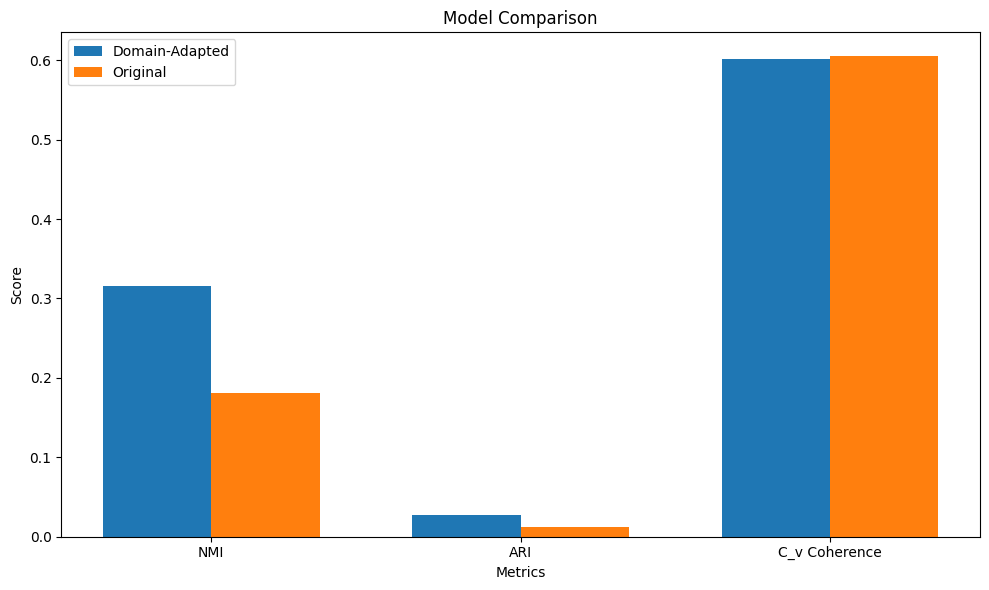

In [22]:
# Step 7: Results and comparison
print("\n===== Step 7: Results & Comparison =====")
results = {
    "Domain-Adapted": domain_results,
    "Original": original_results
}

# Create comparison table
comparison = pd.DataFrame({
    "Metric": ["NMI", "ARI", "Topics", "C_v Coherence"],
    "Domain-Adapted": [
        domain_results["quantitative"]["NMI"],
        domain_results["quantitative"]["ARI"],
        domain_results["quantitative"]["n_topics"],
        domain_results["qualitative"]["C_v Coherence"]
    ],
    "Original": [
        original_results["quantitative"]["NMI"],
        original_results["quantitative"]["ARI"],
        original_results["quantitative"]["n_topics"],
        original_results["qualitative"]["C_v Coherence"]
    ]
})

# Display comparison
print("\nModel Performance Comparison:")
print(comparison)

# Save results
comparison.to_csv(f"{OUTPUT_DIR}/model_comparison.csv", index=False)

# Save topic information
domain_topic_model.get_topic_info().to_csv(f"{OUTPUT_DIR}/domain_adapted_topics.csv", index=False)
original_topic_model.get_topic_info().to_csv(f"{OUTPUT_DIR}/original_topics.csv", index=False)

# Create simple visualization
plt.figure(figsize=(10, 6))

metrics = ["NMI", "ARI", "C_v Coherence"]
x = np.arange(len(metrics))
width = 0.35

domain_values = [
    domain_results["quantitative"]["NMI"],
    domain_results["quantitative"]["ARI"],
    domain_results["qualitative"]["C_v Coherence"]
]

original_values = [
    original_results["quantitative"]["NMI"],
    original_results["quantitative"]["ARI"],
    original_results["qualitative"]["C_v Coherence"]
]

plt.bar(x - width/2, domain_values, width, label='Domain-Adapted')
plt.bar(x + width/2, original_values, width, label='Original')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/model_comparison.png", dpi=300)

end_time = datetime.now()
duration = end_time - start_time
print(f"\nExperiment completed in {duration}")
print(f"Results saved to {OUTPUT_DIR}")